## Imports

In [1]:
import pathlib
import os
import os.path as osp
import sys
import argparse
parent_path = pathlib.Path(os.getcwd()).parent.absolute()
sys.path.append(str(parent_path))

import torch
import torch.nn.functional as F
from torch.nn import Linear
import torch_geometric.transforms as T
from torch_geometric.datasets import MovieLens
from torch_geometric.nn import SAGEConv, to_hetero

from utils.grid_search import grid_search
from utils.visualize import plot_loss, plot_train, plot_val, plot_test, plot_results
from utils.pick_hyperparams import pick_hyperparams

/root/environ/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Read the dataset

In [3]:
path = osp.join(osp.dirname(osp.abspath('')), '../../data/MovieLens')
dataset = MovieLens(path, model_name='all-MiniLM-L6-v2')
data = dataset[0].to(device)

#### Preprocess the dataset

In [4]:
# Add user node features for message passing:
data['user'].x = torch.eye(data['user'].num_nodes, device=device)
del data['user'].num_nodes

# Add a reverse ('movie', 'rev_rates', 'user') relation for message passing:
data = T.ToUndirected()(data)
del data['movie', 'rev_rates', 'user'].edge_label  # Remove "reverse" label.

# Perform a link-level split into training, validation, and test edges:
train_data, val_data, test_data = T.RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    neg_sampling_ratio=0.0,
    edge_types=[('user', 'rates', 'movie')],
    rev_edge_types=[('movie', 'rev_rates', 'user')],
)(data)

#### Define the grid search space

In [2]:
layer_names = ["SAGE"]
encoder_min_num_layers=5
encoder_max_num_layers=7
decoder_min_num_layers=5
decoder_max_num_layers=7
epochs=100
logging_step=10

In [7]:
losses = grid_search(
    layer_names=layer_names,
    encoder_min_num_layers=encoder_min_num_layers,
    encoder_max_num_layers=encoder_max_num_layers,
    decoder_min_num_layers=decoder_min_num_layers,
    decoder_max_num_layers=decoder_max_num_layers,
    epochs=epochs,
    data=data,
    train_data=train_data,
    val_data=val_data,
    test_data=test_data,
    device=device,
    logging_step=logging_step,
)

--->> ('SAGE', 5, True, 5)


/root/environ/lib/python3.10/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch: 010, Loss: 14.5880, Train: 3.0322, Val: 3.0540, Test: 3.0337
Epoch: 020, Loss: 6.0490, Train: 1.7638, Val: 1.8007, Test: 1.7665
Epoch: 030, Loss: 6.6572, Train: 1.1700, Val: 1.2090, Test: 1.1861
Epoch: 040, Loss: 5.9365, Train: 1.1217, Val: 1.1474, Test: 1.1398
Epoch: 050, Loss: 5.4050, Train: 1.1392, Val: 1.1535, Test: 1.1391
Epoch: 060, Loss: 4.8592, Train: 1.1267, Val: 1.1684, Test: 1.1356
Epoch: 070, Loss: 4.2249, Train: 1.2142, Val: 1.2347, Test: 1.2084
Epoch: 080, Loss: 4.0394, Train: 1.2798, Val: 1.2807, Test: 1.2716
Epoch: 090, Loss: 3.9779, Train: 1.2079, Val: 1.2011, Test: 1.1762
Epoch: 100, Loss: 3.8844, Train: 1.1959, Val: 1.2252, Test: 1.2318
--->> ('SAGE', 5, True, 6)
Epoch: 010, Loss: 6.4634, Train: 1.1634, Val: 1.1805, Test: 1.1455
Epoch: 020, Loss: 5.8012, Train: 1.5054, Val: 1.5333, Test: 1.5260
Epoch: 030, Loss: 5.4504, Train: 1.2678, Val: 1.3017, Test: 1.2908
Epoch: 040, Loss: 4.3474, Train: 1.3160, Val: 1.3130, Test: 1.3291
Epoch: 050, Loss: 4.1004, Train: 1

#### Visualize

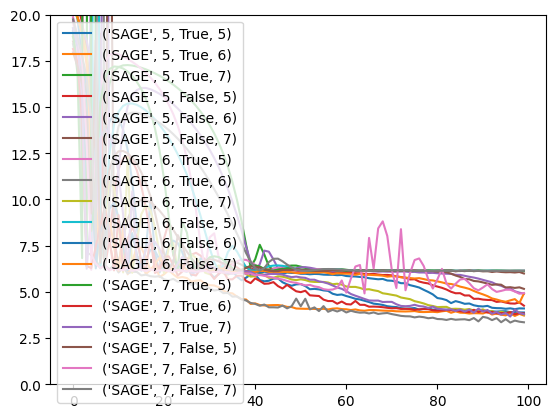

In [8]:
plot_loss(losses, ylim=20)

#### Save output

In [11]:
import json

specs = f"{layer_names}__encoder_{encoder_min_num_layers}_{encoder_max_num_layers}__decoder_{decoder_min_num_layers}_{decoder_max_num_layers}__{epochs}_epochs"
output_path = os.path.join("..", "results", specs+".json")
f = open(output_path, "w")
f.write(json.dumps({str(key): val for key, val in losses.items()}, indent=2))
f.close()

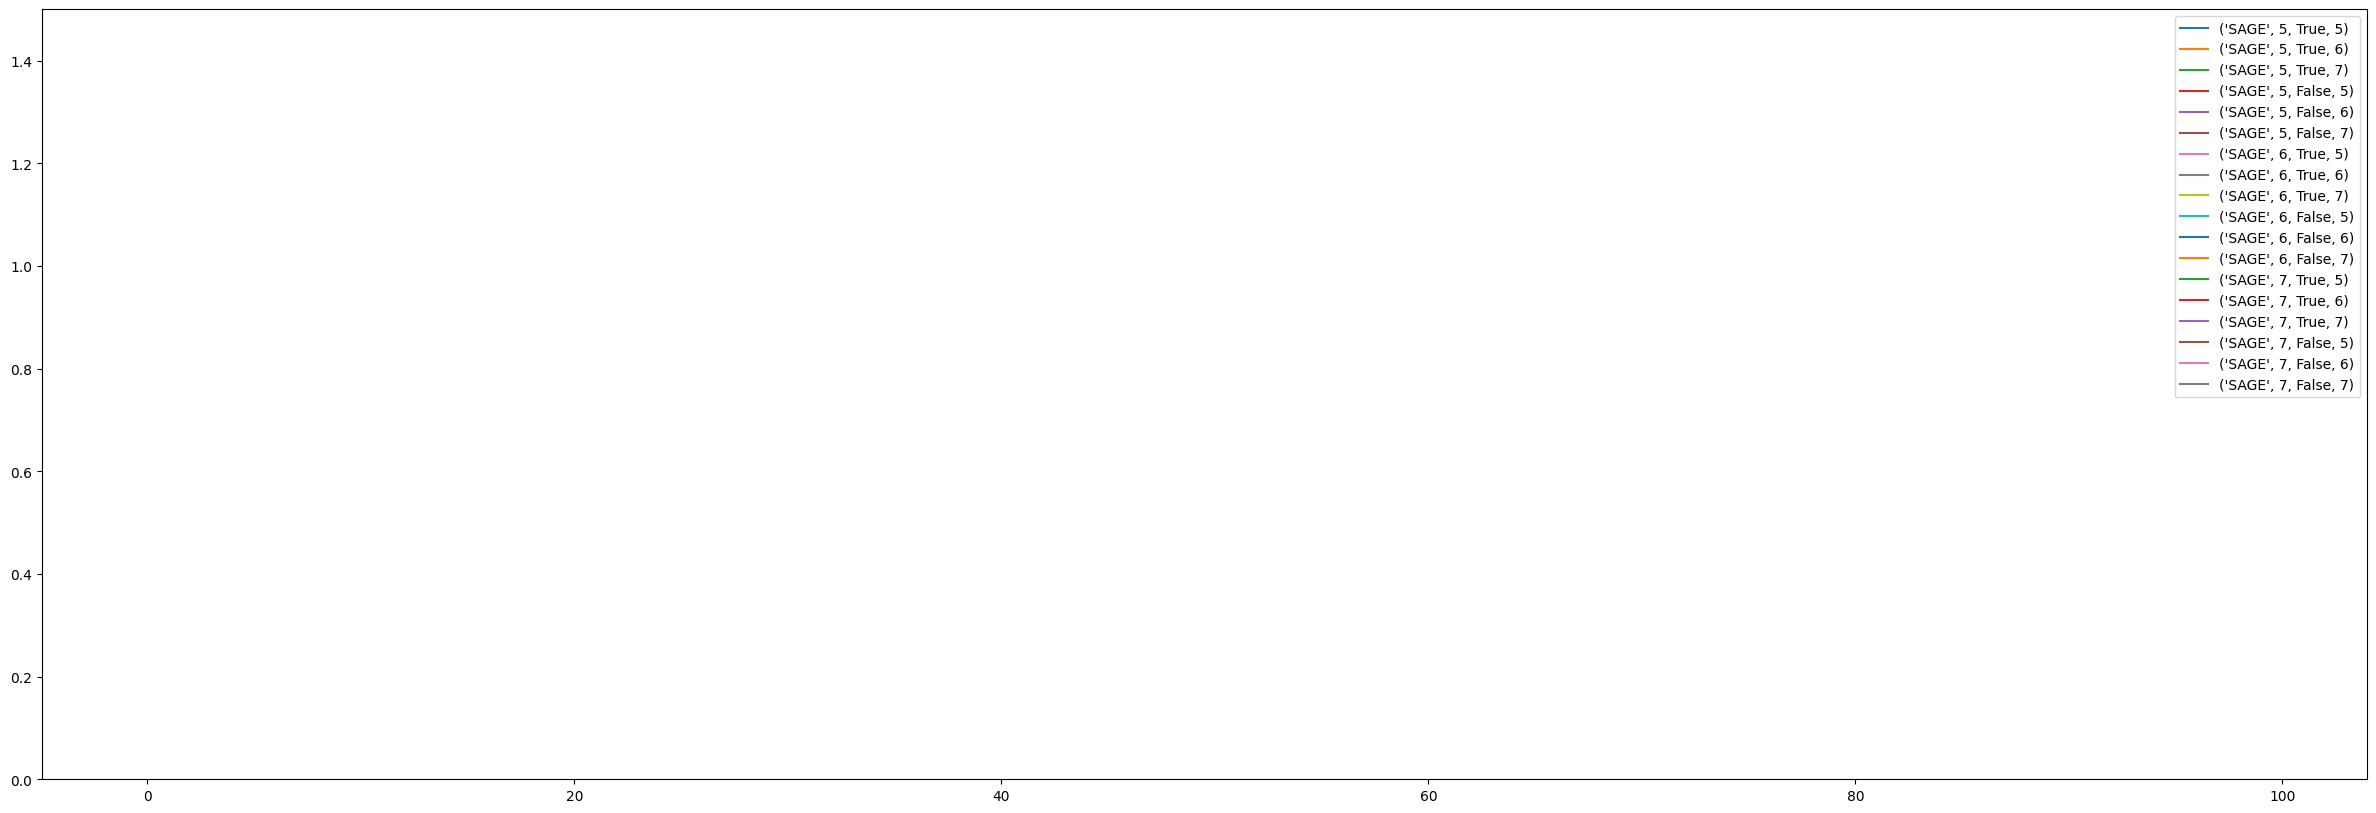

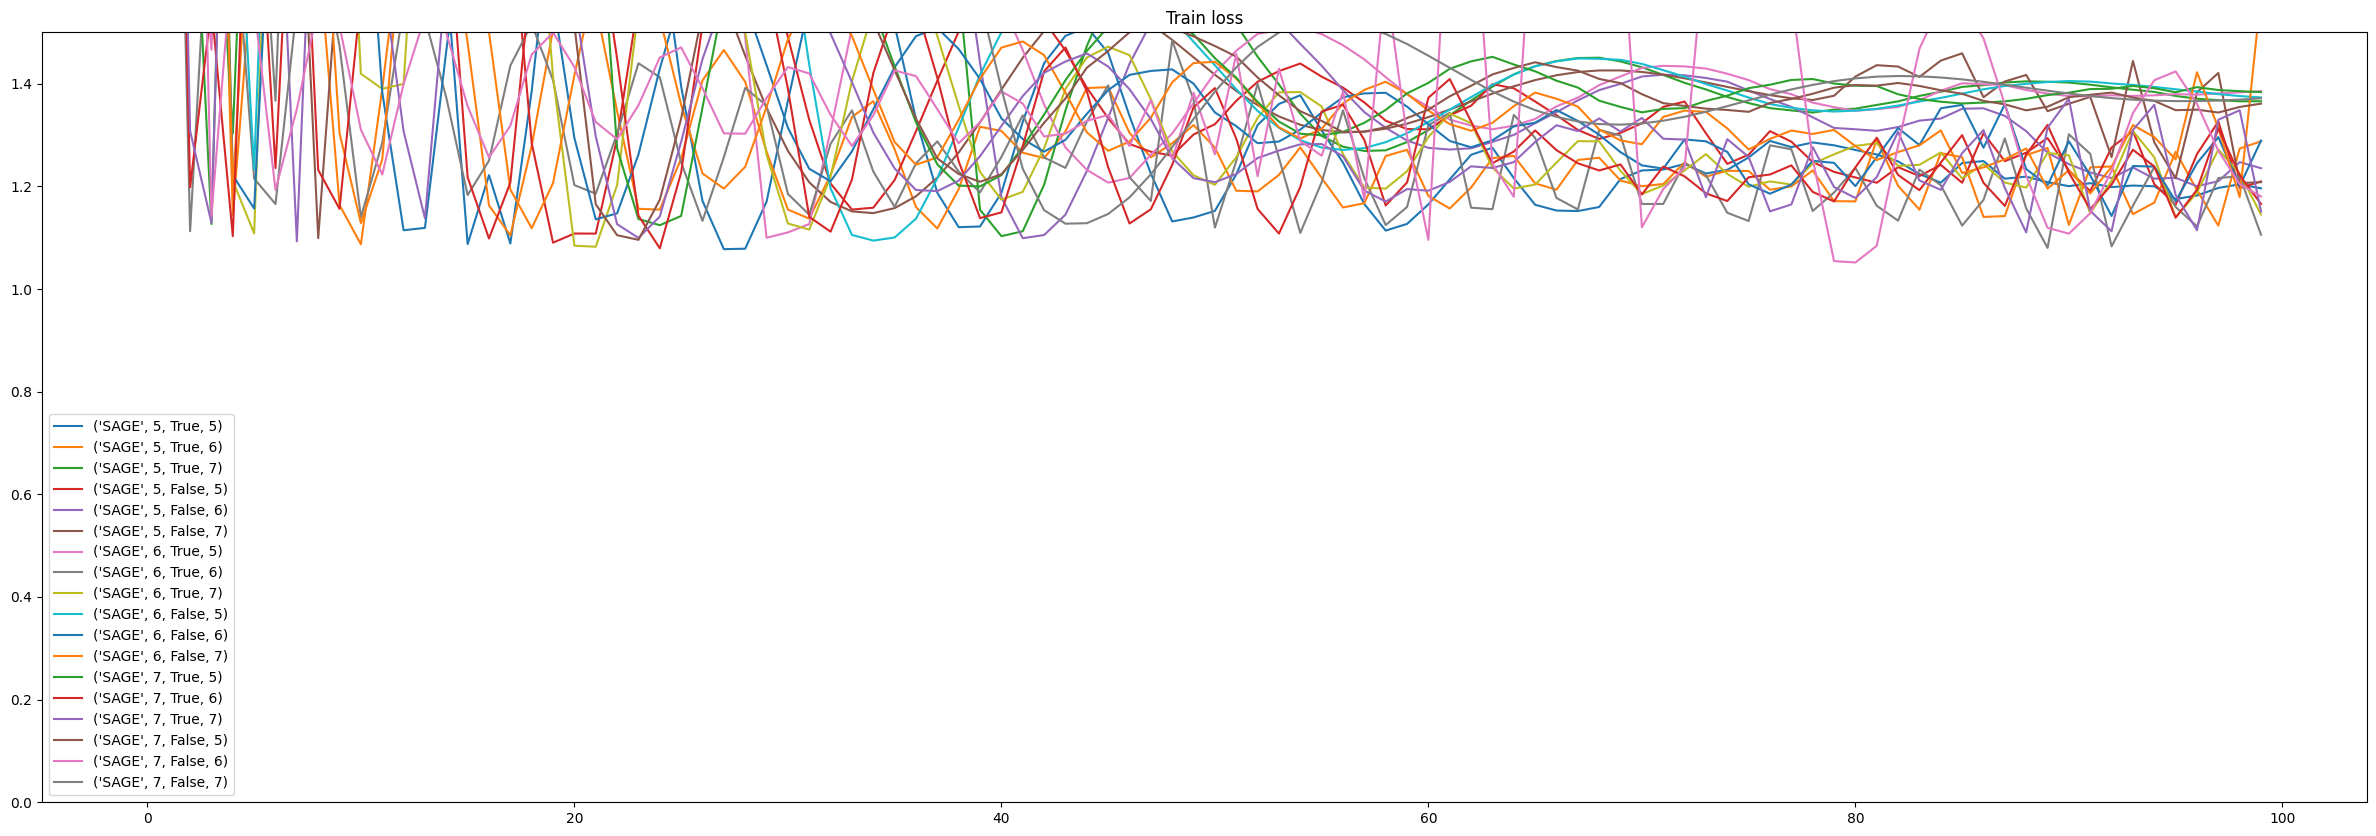

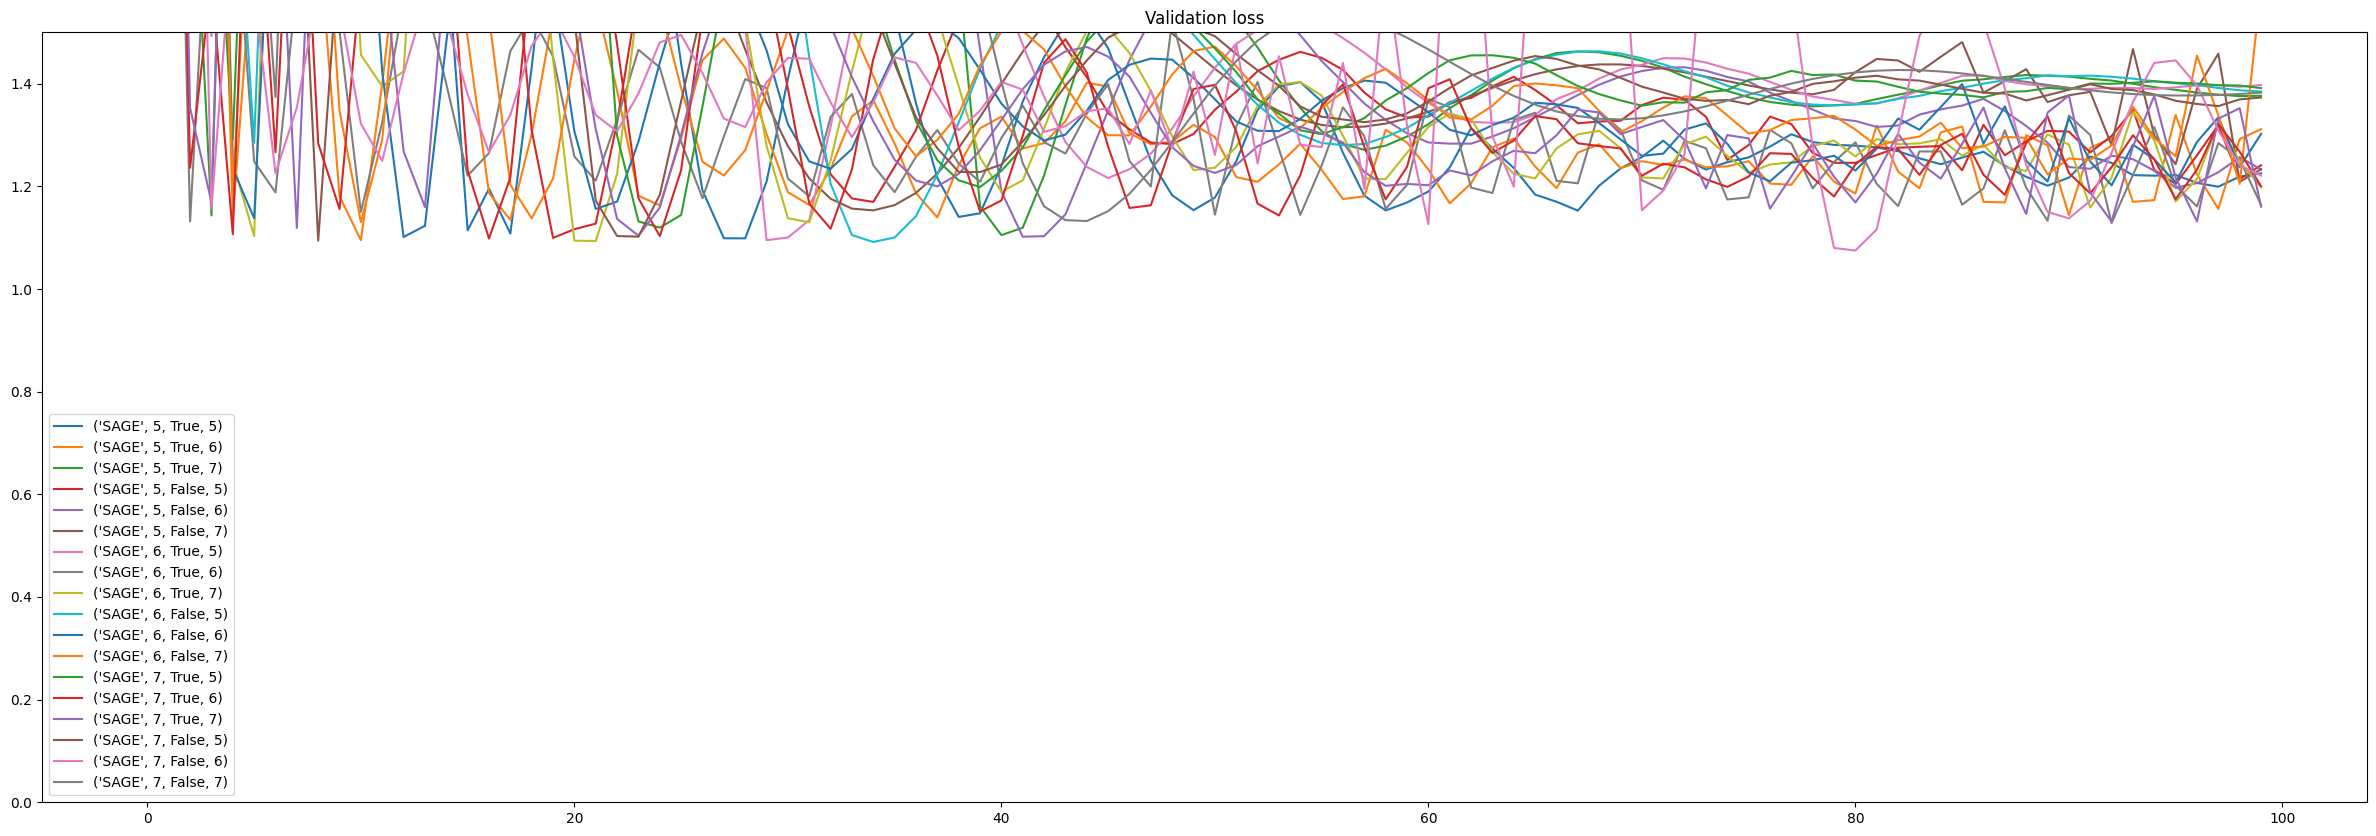

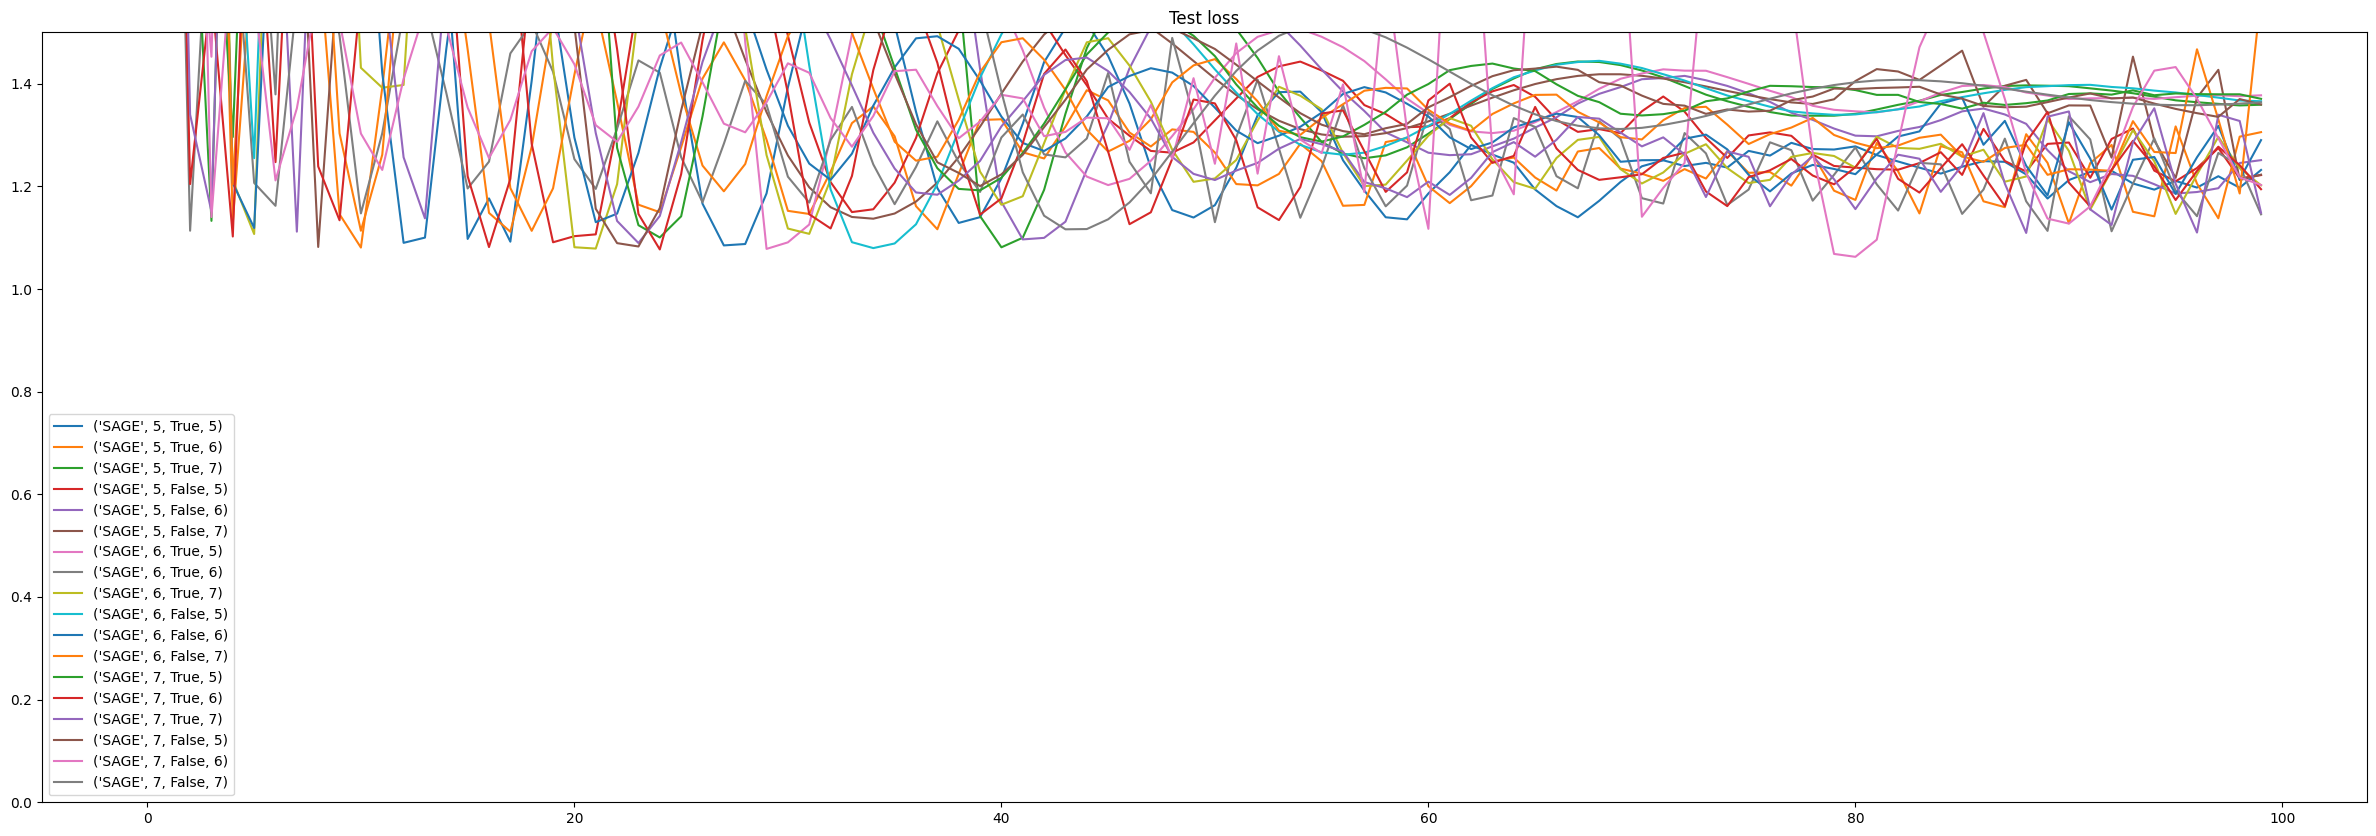

In [8]:
specs = f"{layer_names}__encoder_{encoder_min_num_layers}_{encoder_max_num_layers}__decoder_{decoder_min_num_layers}_{decoder_max_num_layers}__{epochs}_epochs"
output_path = os.path.join("..", "results", specs+".json")
plot_results(output_path)

#### Pick the best hyper-parameters

In [4]:
specs = f"{layer_names}__encoder_{encoder_min_num_layers}_{encoder_max_num_layers}__decoder_{decoder_min_num_layers}_{decoder_max_num_layers}__{epochs}_epochs"
output_path = os.path.join("..", "results", specs+".json")
pick_hyperparams(output_path)

Loss            Hyperparams
--------------  --------------------
Min Loss        ('SAGE', 6, True, 6)
Min Train loss  ('SAGE', 6, True, 6)
Min Val Loss    ('SAGE', 7, True, 7)
Min Test Loss   ('SAGE', 6, True, 6)
